In [62]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import matplotlib as mpl
from tqdm import tqdm

# customize matplotlib styles
mpl.rc('lines', linewidth=4) # default linewidth
mpl.rc('lines', dash_capstyle='round') # default dashed line capstyle
mpl.rc('lines', solid_capstyle='round') # default solid line capstyle
mpl.rc('xtick', labelsize=20) # default label size for xtick
mpl.rc('ytick', labelsize=20) # default label size for ytick
mpl.rc('axes', titlesize=30) # default title size
mpl.rc('axes', labelsize=25) # default label size for all axes
mpl.rc('legend', fontsize=20) # default fontsize for legends
mpl.rc('figure', titlesize=35) # default title size for figures with subplot

% matplotlib inline

# Definition of tube class

In [2]:
class tube:
    r = np.zeros((0,3))
    
    def __init__(self, coordinates):
        for node in coordinates:
            node = node.split(',')
            if (len(node) is 3):
                a = np.array([float(item) for item in node])
                a = a.reshape((1,3))
                self.r = np.concatenate((self.r, a), axis=0)
                
    def r_fine(self):
        if hasattr(self,'_r_fine'):
            return self._r_fine
        tck, u = interpolate.splprep([self.r[:,0], self.r[:,1], self.r[:,2]], s=5, k=3)
        u_fine = np.linspace(0,1,100)
        x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)
        self._r_fine = np.vstack((x_fine,y_fine,z_fine)).T
        return self._r_fine
    
    def avg_y(self):
        return np.mean(self.r[:,1])
    
    def x(self):
        return self.r[:,0]
    def y(self):
        return self.r[:,1]
    def z(self):
        return self.r[:,2]
    
    def x_fine(self):
        return self.r_fine()[:,0]
    
    def y_fine(self):
        return self.r_fine()[:,1]
    
    def z_fine(self):
        return self.r_fine()[:,2]
    
    def plot(self,ax=None,mode='true'):
        assert mode is 'true' or 'fine'

        if ax is None:
            fig = plt.figure(figsize=(12,10))
            ax = fig.add_subplot(111, projection='3d')
            
        
        if mode is 'true':
            x, y, z = self.x(), self.y(), self.z()
        elif mode is 'fine':
            x, y, z = self.x_fine(), self.y_fine(), self.z_fine()
            
        ax.plot(z,x,y)
        return ax
            

# Check height of tubes

In [3]:
directory = os.path.expanduser("~/research/cnt_mesh_fiber")

tubes = []

for i in range(1,100):
    filename = os.path.join(directory, "tube"+str(i)+".pos.dat")
    if (not os.path.isfile(filename)):
        continue
    print("reading file: {}".format(filename))
    with open(filename) as file:
        for line in file:
            r = line.strip().split(";")
            r = r[1:]
            tubes.append(tube(r))

# make sure the last tube is stored and read properly
if (tubes[-1].r.shape!=tubes[0].r.shape): tubes.pop(-1)
            
print("number of tubes: {}".format(len(tubes)))
avg_y = np.array([tube.avg_y() for tube in tubes[:]])

avg_number_of_sections = np.mean([tube.r.shape[0] for tube in tubes])
print("average number of sections per tube: {}".format(int(avg_number_of_sections)))

reading file: /Users/amirhossein/research/cnt_mesh_fiber/tube1.pos.dat
number of tubes: 3789
average number of sections per tube: 16


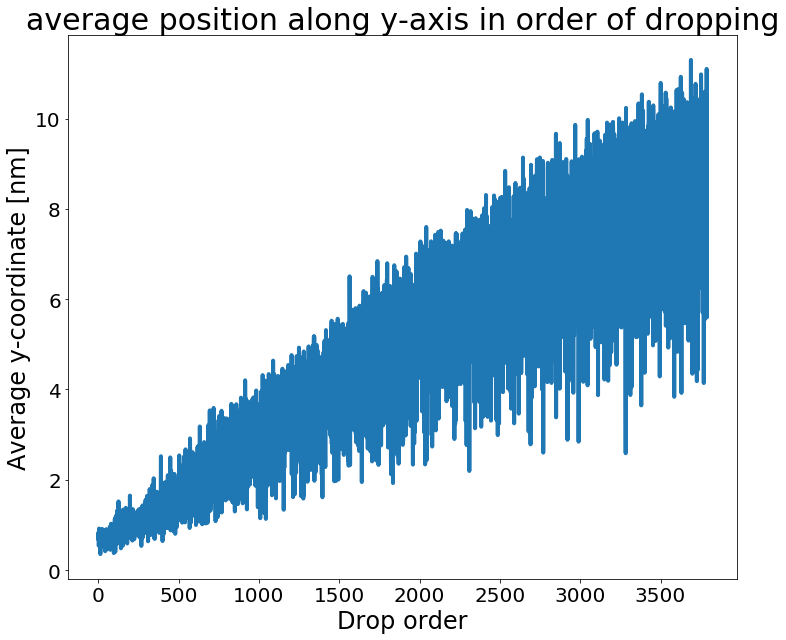

In [4]:
min_order, max_order = 0, len(tubes)
drop_order = np.linspace(min_order,max_order, max_order-min_order)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)
ax.plot(drop_order,avg_y[min_order:max_order], linewidth=4)
ax.set_title("average position along y-axis in order of dropping",fontsize=30)
ax.set_xlabel("Drop order",fontsize=24)
ax.set_ylabel("Average y-coordinate [nm]",fontsize=24)
ax.tick_params(labelsize=20)

# Draw individual CNTs in the container

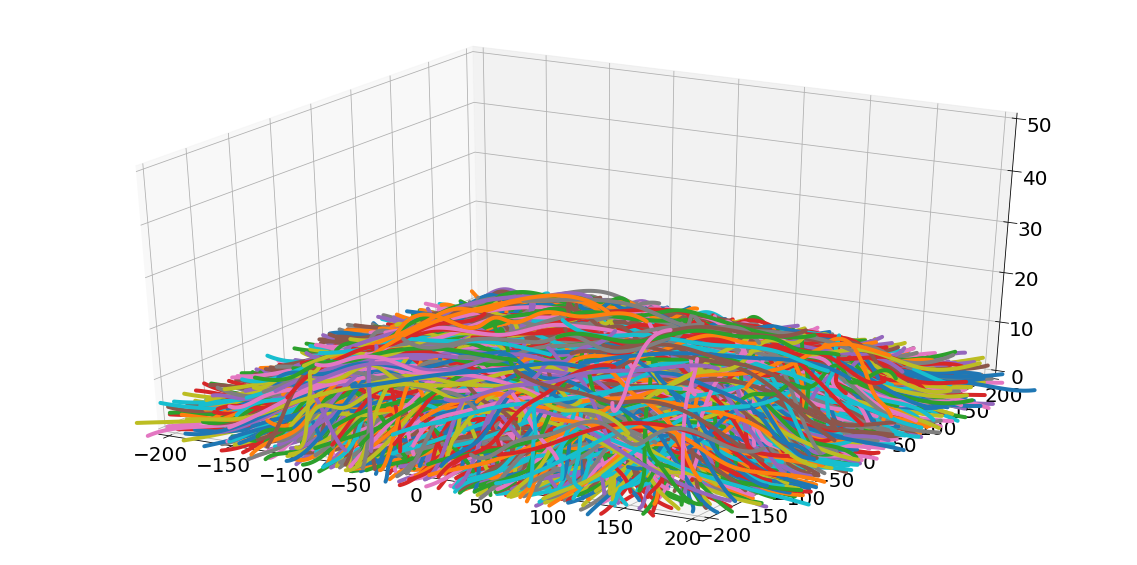

In [11]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111,projection='3d')
# ax.set_aspect('equal')

begin=0
n_tube=len(tubes)-1

for t in tubes[begin:begin+n_tube]:
    ax = t.plot(ax=ax,mode='fine')

ax.set_xlim([-200,200])
ax.set_ylim([-200,200])
_ = ax.set_zlim([0,50])

# Working with quaternions for rations

Rotation is three dimension as a rotation by around axis $\vec{b}$ by angle $\alpha$. We can specify the rotation axis via [direction cosines](https://en.wikipedia.org/wiki/Direction_cosine)

$$ \cos(\beta_x) = \frac{\vec{b}.\hat{x}}{|b|} \quad,\quad \cos(\beta_y) = \frac{\vec{b}.\hat{y}}{|b|} \quad,\quad \cos(\beta_z) = \frac{\vec{b}.\hat{z}}{|b|} $$

Therefore, the quaternion elements, $\pmb{q}=[q_0, q_1, q_2, q_3]^T$, are given by 

$$
\begin{split}
q_0 = & ~\cos(\alpha/2) \\
q_1 = & ~\sin(\alpha/2) \cos(\beta_x) \\
q_2 = & ~\sin(\alpha/2) \cos(\beta_y) \\
q_3 = & ~\sin(\alpha/2) \cos(\beta_z) \\
\end{split}
$$

The rotation matrix for normalized quaternion is
$$
R = \begin{bmatrix}
q_0^2 + q_1^2 - q_2^2 - q_3^2 &  2(q_1 q_2 - q_0 q_3) &  2(q_0 q_2 + q_1 q_3) \\
2(q_1 q_2 + q_0 q_3) & q_0^2 - q_1^2 + q_2^2 - q_3^2 &  2(q_2 q_3 - q_0 q_1) \\
2(q_1 q_3 - q_0 q_2) & 2( q_0 q_1 + q_2 q_3) & q_0^2 - q_1^2 - q_2^2 + q_3^2 
\end{bmatrix}
$$



References:
- https://en.wikipedia.org/wiki/Conversion_between_quaternions_and_Euler_angles

In [6]:
def direction_cosine(axis):
    assert len(axis) is 3
    axis = axis / np.linalg.norm(axis)
    cosine = np.zeros((3,1))
    cosine[0] = axis.dot([1,0,0])
    cosine[1] = axis.dot([0,1,0])
    cosine[2] = axis.dot([0,0,1])
    return cosine

def get_quaternion(axis,alpha):
    beta = direction_cosine(axis)
    quaternion = np.zeros((4,1))
    quaternion[0] = np.cos(alpha/2)
    quaternion[1] = np.sin(alpha/2)*beta[0]
    quaternion[2] = np.sin(alpha/2)*beta[1]
    quaternion[3] = np.sin(alpha/2)*beta[2]
    return quaternion

# gets rotation matrix from quaternion
def rotation_from_quaternion(q):
    R = np.zeros((3,3))
    R[0,0] = q[0]**2+q[1]**2-q[2]**2-q[3]**2
    R[0,1] = 2*(q[1]*q[2]-q[0]*q[3])
    R[0,2] = 2*(q[0]*q[2]+q[1]*q[3])
    R[1,0] = 2*(q[1]*q[2]+q[0]*q[3])
    R[1,1] = q[0]**2-q[1]**2+q[2]**2-q[3]**2
    R[1,2] = 2*(q[2]*q[3]-q[0]*q[1])
    R[2,0] = 2*(q[1]*q[3]-q[0]*q[2])
    R[2,1] = 2*(q[0]*q[1]+q[2]*q[3])
    R[2,2] = q[0]**2-q[1]**2-q[2]**2+q[3]**2    
    return R

axis = np.array([0,1,0])
alpha = np.pi/2
qt = get_quaternion(axis,alpha)
Rot  = rotation_from_quaternion(qt)

v = np.array([1,0,0])
v = np.reshape(v,(3,1))
w = np.matmul(Rot,v)
print(w)


[[ 2.22044605e-16]
 [ 0.00000000e+00]
 [-1.00000000e+00]]


# Interpolate 3d curve using Bsplines

## Spline functions:
**Order**: A spline function of order n is a piecewise polynomial function of degree n-1 in a variable x.

**Knots**: The places where the pieces meet are known as knots.

## Implementation

Use `scipy.interpolate` package to calculate spline parameters ans later one evaluate spline curves using calculated parameters.

- `splprep` is used to calculated spline parameters:

    - The normal output is a 3-tuple, `(t,c,k)` , containing the knot-points, `t` , the coefficients `c` and the order `k` of the spline.
    - The output `u` is the parameter array, which would produce the equivalent of input points for calculating the spline curves.
    - `x_test, y_test, z_test = interpolate.splev(u, tck)` would produce such points in 3d space.

- `splev(x, tck, der=0, ext=0)` <br> Evaluate a B-spline or its derivatives. Given the knots and coefficients of a B-spline representatio, evaluate the value of the smoothing polynomial and its derivatives.

Look here for more: https://stackoverflow.com/questions/18962175/spline-interpolation-coefficients-of-a-line-curve-in-3d-space

In [ ]:
fig = plt.figure(figsize=(20,15))
ax3d = fig.add_subplot(111, projection='3d')

for t in tubes[3000:3001]:
    x_true = t.x()
    y_true = t.z()
    z_true = t.y()

    tck, u = interpolate.splprep([x_true,y_true,z_true], s=5, k=3)
    u_fine = np.linspace(0,1,100)
    x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)
    r_fine = np.vstack((x_fine,y_fine,z_fine)).T
    print(r_fine.shape)

    ax3d.plot(x_fine, y_fine, z_fine)


ax3d.set_xlim([-200,200])
ax3d.set_ylim([-200,200])
_ = ax3d.set_zlim([0,50])

# Check distance between CNT fine coordinates

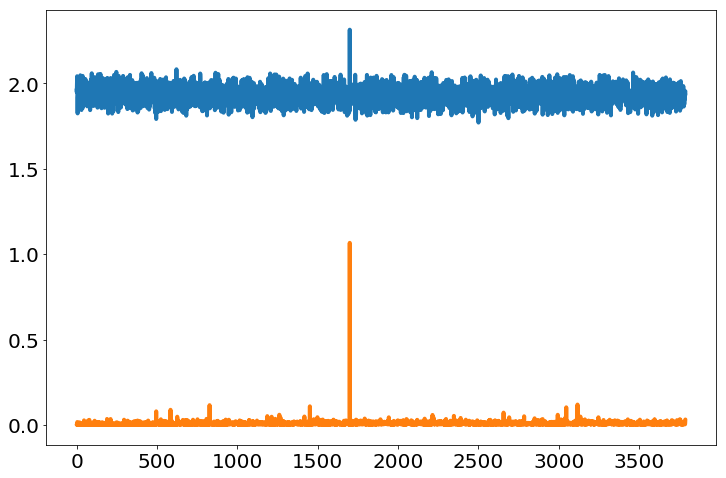

In [33]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

m = []
std = []

for t in tubes[:-1]:
    dr = t.r_fine()[0:-2,:]-t.r_fine()[1:-1,:]
    dr = np.linalg.norm(dr,axis=1)
    m.append(np.mean(dr))
    std.append(np.std(dr))

ax.plot(m)
ax.plot(std)


# Get minimum distance between each bundle


100%|██████████| 3789/3789 [42:56<00:00,  1.47it/s]


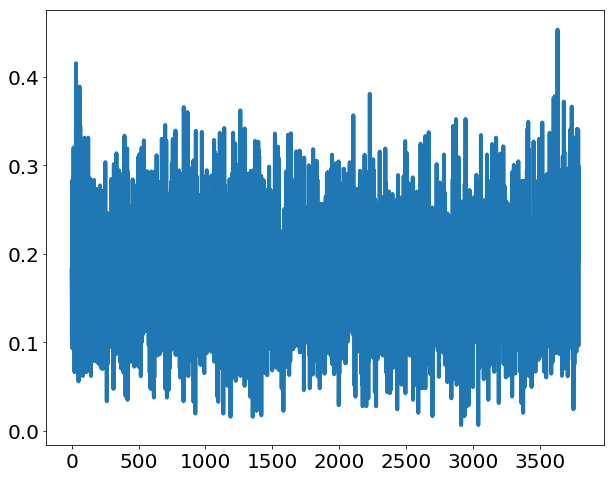

In [103]:
n=len(tubes)
    
min_dist = np.full((n,n),1.e4)

for i, t1 in enumerate(tqdm(tubes[:n])):
    for j in range(i+1,n):
        t2 = tubes[j]
        temp = np.zeros((t1.r_fine().shape[0],t2.r_fine().shape[0],3))
        for d in range(3):
            x,y = np.meshgrid(t1.r_fine()[:,d],t2.r_fine()[:,d])
            temp[:,:,d] = x-y
        temp = np.linalg.norm(temp,axis=2)
        min_dist[i,j] = min_dist[j,i] = np.amin(temp)
                
min_dist_1d = np.amin(min_dist,axis=1)

for i in range(min_dist.shape[0]):
    min_dist[i,i] = 0

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)

ax.plot(min_dist_1d)

0.006791488753179545


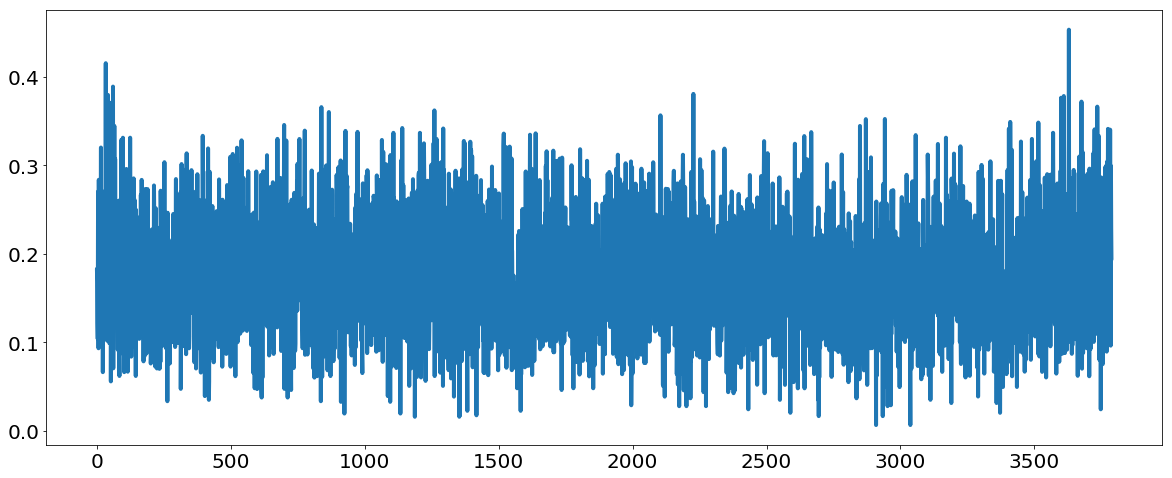

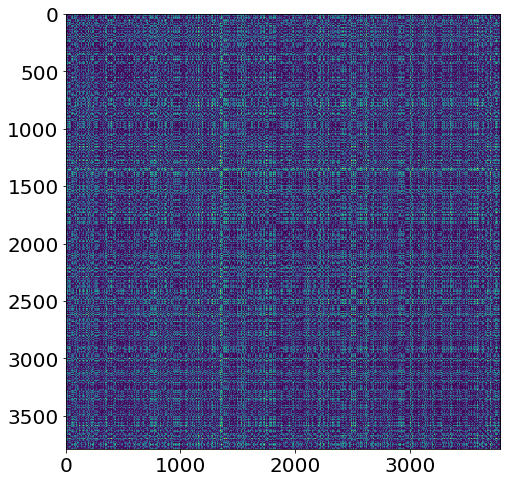

In [106]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,1,1)

ax.plot(min_dist_1d)

print(np.amin(min_dist_1d))

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)

ax.imshow(min_dist)